### UNET Segmentation example with added documentation -- Carolyn Johnston, 2021

### Derived from the original colab example as described below

This document contains all of the original document, plus additional code and documentation that I added while exploring the objects and functions involved. I tried to add "CJ" wherever I added something. 

##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image segmentation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/segmentation">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/segmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial focuses on the task of image segmentation, using a modified <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a>.

## What is image segmentation?

In an image classification task the network assigns a label (or class) to each input image. However, suppose you want to know the shape of that object, which pixel belongs to which object, etc. In this case you will want to assign a class to each pixel of the image. This task is known as segmentation. A segmentation model returns much more detailed intofmation about the image. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.

This tutorial uses the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), created by Parkhi *et al*. The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the train and test split). Each image includes the corresponding labels, and pixel-wise masks. The masks are class-labels for each pixel. Each pixel is given one of three categories :

*   Class 1 : Pixel belonging to the pet.
*   Class 2 : Pixel bordering the pet.
*   Class 3 : None of the above/ Surrounding pixel.

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-ita138cb
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-ita138cb


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing 

import tensorflow_datasets as tfds

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Download the Oxford-IIIT Pets dataset

The dataset is [available from TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet). The segmentation masks are included in version 3+.

#### Note from CJ: the info object is a bit mysterious, and maybe not actually required. "Dataset" is a dictionary with two keys, 'train' and 'test'. These keys point to 'PrefetchDataset' objects.

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [ ]:
dataset.keys()

dict_keys(['test', 'train'])

In [ ]:
type(dataset['train'])

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

Note: dataset['train'] is iterable. Each item is a dictionary 

In [ ]:
# explore each item in the dataset.
import numpy as np
for item in dataset['train']: 
  # item is a dict
  print("KEYS in 'item':")
  print('\n'.join(item.keys()))
  print("FILE NAME:")
  print(item['file_name'])
  print("image SHAPE:")
  print(item['image'].shape) # check its shape
  print("label SHAPE (has no dimensions and is therefore a scalar):")
  print(type(item['label'])) # label is another tensor
  print(item['label'].shape) # label tensor has no dimensions? Is it a scalar?
  print("label VALUE:")
  print(item['label'].numpy()) # it's a scalar! With value 33
  print("segmentation_mask SHAPE:")
  print(item['segmentation_mask'].shape) #segmentation mask is a single-band image of the same size
  print("species VALUE:")
  print(item['species'].numpy()) # a number, value 0.
  break

KEYS in 'item':
file_name
image
label
segmentation_mask
species
FILE NAME:
tf.Tensor(b'Sphynx_158.jpg', shape=(), dtype=string)
image SHAPE:
(500, 500, 3)
label SHAPE (has no dimensions and is therefore a scalar):
<class 'tensorflow.python.framework.ops.EagerTensor'>
()
label VALUE:
33
segmentation_mask SHAPE:
(500, 500, 1)
species VALUE:
0


 In addition, the image color values are normalized to the `[0,1]` range. Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

The dataset already contains the required splits of test and train and so continue to use the same split.

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
# integer rounding down, I think
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
print(TRAIN_LENGTH)

3680



You can get this information without having to use a separate info object. Prevents de-synchronization.



In [ ]:
print(len(dataset['train']))

3680


This is where load_image() is called. load_image() performs normalization of the image and segmentation label, and resizes to 128x128. It also gets rid of the other data items that are not being used. 

In [ ]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

A ParallelMapDataset is apparently just the result of a map operation applied to a dataset. Each item in the ParallelMapDataset is a tuple.

The first element in the tuple is the image tensor, and the second is the segmentation mask tensor.

In [ ]:
for item in train_images:
  #each item is a tuple. Iterate over the tuple.
  for thing in item:
    print(thing)
  break

tf.Tensor(
[[[0.01960784 0.01273648 0.01374272]
  [0.0214815  0.01618605 0.01246458]
  [0.01385474 0.01740866 0.0156317 ]
  ...
  [0.00884842 0.00308862 0.00596852]
  [0.00824621 0.00824621 0.00459559]
  [0.02745098 0.01176471 0.01213235]]

 [[0.01471546 0.01599265 0.01032954]
  [0.01438323 0.01438323 0.01539618]
  [0.01582893 0.01213905 0.01398399]
  ...
  [0.00665882 0.00274395 0.00377891]
  [0.00795324 0.00795324 0.00101294]
  [0.01200023 0.01200023 0.01481886]]

 [[0.01036209 0.01726122 0.01381166]
  [0.01331667 0.01331667 0.01331667]
  [0.01387963 0.01963944 0.0146762 ]
  ...
  [0.00707816 0.00707816 0.00707816]
  [0.01545458 0.01176471 0.01152631]
  [0.01783088 0.00998775 0.01966912]]

 ...

 [[0.02640931 0.02875594 0.03659907]
  [0.01420898 0.02989526 0.03590016]
  [0.02821595 0.03529412 0.03366747]
  ...
  [0.01589786 0.02064951 0.02821595]
  [0.02027516 0.02316177 0.03469478]
  [0.02071078 0.02359069 0.03143382]]

 [[0.02352941 0.02745098 0.03529412]
  [0.03247549 0.0370998  0

The following class performs a simple augmentation of randoly-flipping an image.
See the [image augmentation tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation) for more on image augmentation.

Note the comment in the code: since both augment_inputs and augment_labels use the same seed, they'll apply the same random changes to every image/label pair.


In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same randomn changes.
    self.augment_inputs = preprocessing.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = preprocessing.RandomFlip(mode="horizontal", seed=seed)
  
  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

Build the input pipeline, applying the Augmentation after batching the inputs.

CJ:
- cache() caches the dataset in memory or local storage. Cache will produce exactly the same elements during each iteration through the dataset, so always follow it with shuffle(). 
- Shuffle() randomly shuffles the elements of a dataset. [Here](https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset) is a description of exactly what shuffle() does. If the buffer_size is less than the size of the full dataset (as in this case, 1000 vs 3680), then my intuition is that the shuffling will not be a perfect random selection because the front of the new list will be overselected from the initial contents of the buffer. 
- batch(): combines consecutive elements of the dataset into batches. if each element was a 3-tensor, then the result will have a fourth dimension of length batch_size.
- repeat(): it is odd to see repeat following batch, it's usually the other way around, but maybe these functions commute. repeat() reinitializes the shuffle buffer, so you can keep feeding data for more epochs (see the above link). With no argument (it would usually be the count of epochs), repeat() will repeat indefinitely.  
- map(Augment()): Applies a random flip (as above) to each element. Again, it is not clear what it does when batch() is called before it.  
- prefetch(buffer_size=tf.data.AUTOTUNE): Most dataset input pipelines should end with a call to prefetch. This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements. Like other Dataset methods, prefetch operates on the elements of the input dataset. It has no concept of examples vs. batches. examples.prefetch(2) will prefetch two elements (2 examples), while examples.batch(20).prefetch(2) will prefetch 2 elements (2 batches, of 20 examples each).

There's some good explanations of what's going on [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

And here's what looks like [a good article on building dataset pipelines](https://www.tensorflow.org/guide/data).

Below is the resulting dataset from applying all the transforms to the input dataset. This becomes the new input dataset.

In [ ]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

CJ: Take a look at an image example and its corresponding mask from the dataset. Note that, in spite of the title, we haven't yet calculated a predicted mask.

The mask has 3 channels. This is using Trimap coding, as described here:

_Standard methods are initialized with a trimap, a partition of the image into three regions: a definite foreground, a definite background, and a blended region where pixels are considered as a mixture of foreground and background colors._ 

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

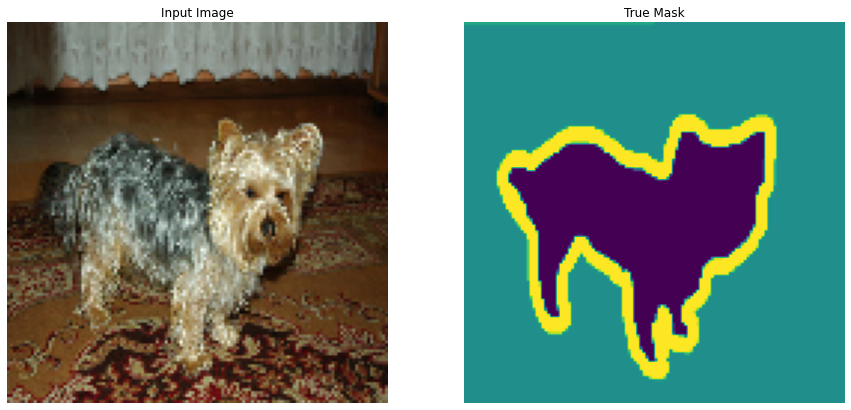

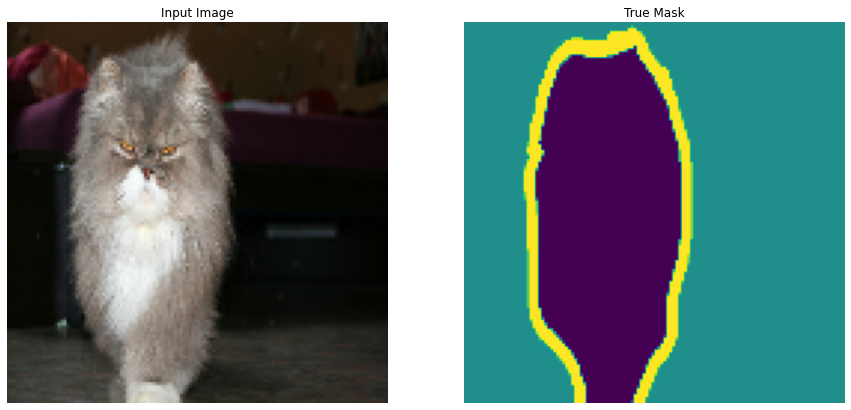

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## Define the model
The model being used here is a modified [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features and reduce the number of trainable parameters, you will use a pretrained model - MobileNetV2 - as the encoder. For the decoder, you will use the upsample block, which is already implemented in the [Pix2pix tutorial](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) tutorial in the TensorFlow Examples repo.


As mentioned, the encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in `tf.keras.applications`. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [ ]:
# define the encoder
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)


9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# CJ: get a summary of the base layers in the model.
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

CJ: You won't retrain this network. You'll use the activations of only some of the  layers in your model. 

the base_model.input object defines the dimensions and type of the input tensor, which in this case is always a 3-channel 128x128 unnormalized picture.

In [ ]:

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

In [ ]:
# input to the base model
base_model.input

<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'input_1')>

CJ: Below, note that the down_stack summary stops when you reach the deepest layer that is an output of the down_stack.

It doesn't include the 4 layers that came in the base_model after block_16_project. 

So the model keeps track of not only the outputs you named, but also of all the intermediate layers required to compute the outputs.

But when you _call_ down_stack on an input, you will only get the data output from the layers you specified when you created down_stack.

In [ ]:
# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

down_stack.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

CJ: The decoder/upsampler is 'simply' a series of upsample transforms implemented in TensorFlow examples.

The function:
Conv2dTranspose(filters, size, norm_type='batchnorm', apply_dropout=False)

with strides=2 upsamples the input image by a factor of 2. The output size is also affected as follows by padding instructions:

```
new_rows = ((rows - 1) * strides[0] + kernel_size[0] - 2 * padding[0] +
output_padding[0])
new_cols = ((cols - 1) * strides[1] + kernel_size[1] - 2 * padding[1] +
output_padding[1])
```

Here's the code from pix2pix to define each transform in the decoder:

```
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):

  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result
```

CJ: below is the code for the decoder part of the model. The first number passed to the upsample() function is the number of filters in the output, and the second is the filter size. So the output from the first transform in up_stack will be 8x8x512, the second will be 16x16x256, and so on.

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

CJ: This block of code gives a deeper look at what the Unet is doing when it creates skip connections.

In [ ]:
def endl():
  print("\n")

# CJ: Here's some code to look at what you've got. First, look at what's in the down_stack.
inputs = tf.keras.layers.Input(shape=[128, 128, 3])
skips = down_stack(inputs)
type(skips)
len(skips)
skips[1]
x = skips[-1]
skips = reversed(skips[:-1])
# for item in skips: print(item)
print("Size of deepest layer in the encoder")
print(x) # this is the bottommost layer in the down_stack, of dimension (4,4,320).
endl()

# This is the heart of the unet
# Upsampling and establishing the skip connections.
# CJ: Start the iteration with the final feature layer in 'down_stack' 
# which is (4, 4, 320).
# The first transform up(x) in the iteration over up_stack upsamples it to (8,8,512).
# the 3rd call concatenates this output to the 1st layer in 'skips' which is (8, 8, 576).
# The resulting total number of filters is 1088.
ii=1
for up, skip in zip(up_stack, skips):
    x = up(x) 
    print(f"Tensor size before concatenation: step {ii}")
    print(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])
    print(f"Tensor size after concatenation: step {ii}")
    print(x)
    ii+=1
    endl()

  # Now look at the last layer in the model: it's another upsampling transform. 
  # The size of the image is back to 128x128,
  # and the number of channels in the output is 'output_channels',
  # which is the number of classes in your segmentation
  # result. 
  # you get the output by applying this transform, 'last', to the 
  # final output from the iteration, which was 64 x 64 x (64 + 96) = 64x64x160
channels_out = 3
last = tf.keras.layers.Conv2DTranspose(
    filters=channels_out, kernel_size=3, strides=2,
    padding='same')  #64x64 -> 128x128

# print out the size of the next-but-last tensor in the pipeline
x = last(x)
print("Final tensor output")
print(x)
#  tf.keras.Model(inputs=inputs, outputs=x)

Size of deepest layer in the encoder
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 320), dtype=tf.float32, name=None), name='model/block_16_project/Conv2D:0', description="created by layer 'model'")


Tensor size before concatenation: step 1
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 512), dtype=tf.float32, name=None), name='sequential/re_lu/Relu:0', description="created by layer 'sequential'")
Tensor size after concatenation: step 1
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 1088), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


Tensor size before concatenation: step 2
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 256), dtype=tf.float32, name=None), name='sequential_1/re_lu_1/Relu:0', description="created by layer 'sequential_1'")
Tensor size after concatenation: step 2
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 448), dtype=tf.float32, name=None), name='concatenate_1/concat:0', descri

CJ: The unet model is essentially just the down_stack, followed by the up_stack, with skip connections defined by concatenation.

In [ ]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  # down_stack is a model, and therefore is callable with the inputs to the unet.
  # calling it returns the 5 layers that were included in the down_stack definition.
  # skips is a list of 5 items, each of which is a KerasTensor with the 
  # shape determined by the layer.
  skips = down_stack(inputs)

  # this returns the last layer, to initialize the upsampling.
  x = skips[-1]

  # this reverses the order of the layers in skips
  skips = reversed(skips[:-1])

# at this point, 'skips' is a list of layers with shapes:
# (8,8,576), (16, 16, 192), (32, 32, 144), (64, 64, 96)
# and 'up_stack' is a list of transforms converting their inputs to shapes:
# (8, 8, 512), (16, 16, 256), (32, 32, 128), (64, 64, 64).



  # This is the heart of the unet
  # Upsampling and establishing the skip connections.
  # Start the iteration with the final feature layer in 'down_stack' 
  # which is (4, 4, 320).
  # The first call in the iteration upsamples it to (8,8,320).
  # the 3rd call concatenates this to the 1st layer in 'skips' which is (8, 8, 576).
  for up, skip in zip(up_stack, skips):
    x = up(x) 
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

CJ: Note that on the number of filters on the last layer is set to the number of `output_channels`. This will be one output channel per class.

## Train the model

Now, all that is left to do is to compile and train the model. 

SInce this is a multiclass classification problem a `CategoricalCrossentropy` with `from_logits=True` is the standard loss function. 

Use `losses.SparseCategoricalCrossentropy(from_logits=True)` since the labels are scalar integers instead of vectors of scores for scores for each class .for each pixel. 

When running inference, the label assigned to the pixel is the channel with the highest value. This is what the `create_mask` function is doing.

In [ ]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

CJ: Have a quick look at the resulting model architecture. This is cool: it's a very clear diagram. Every block represents a transform, and gives the dimensions of its tensor input and output.

Note that the entire encoder part of the model is represented by the single second block labeled 'model: Functional' which has 5 outputs. These are the ones that were defined in down_stack.

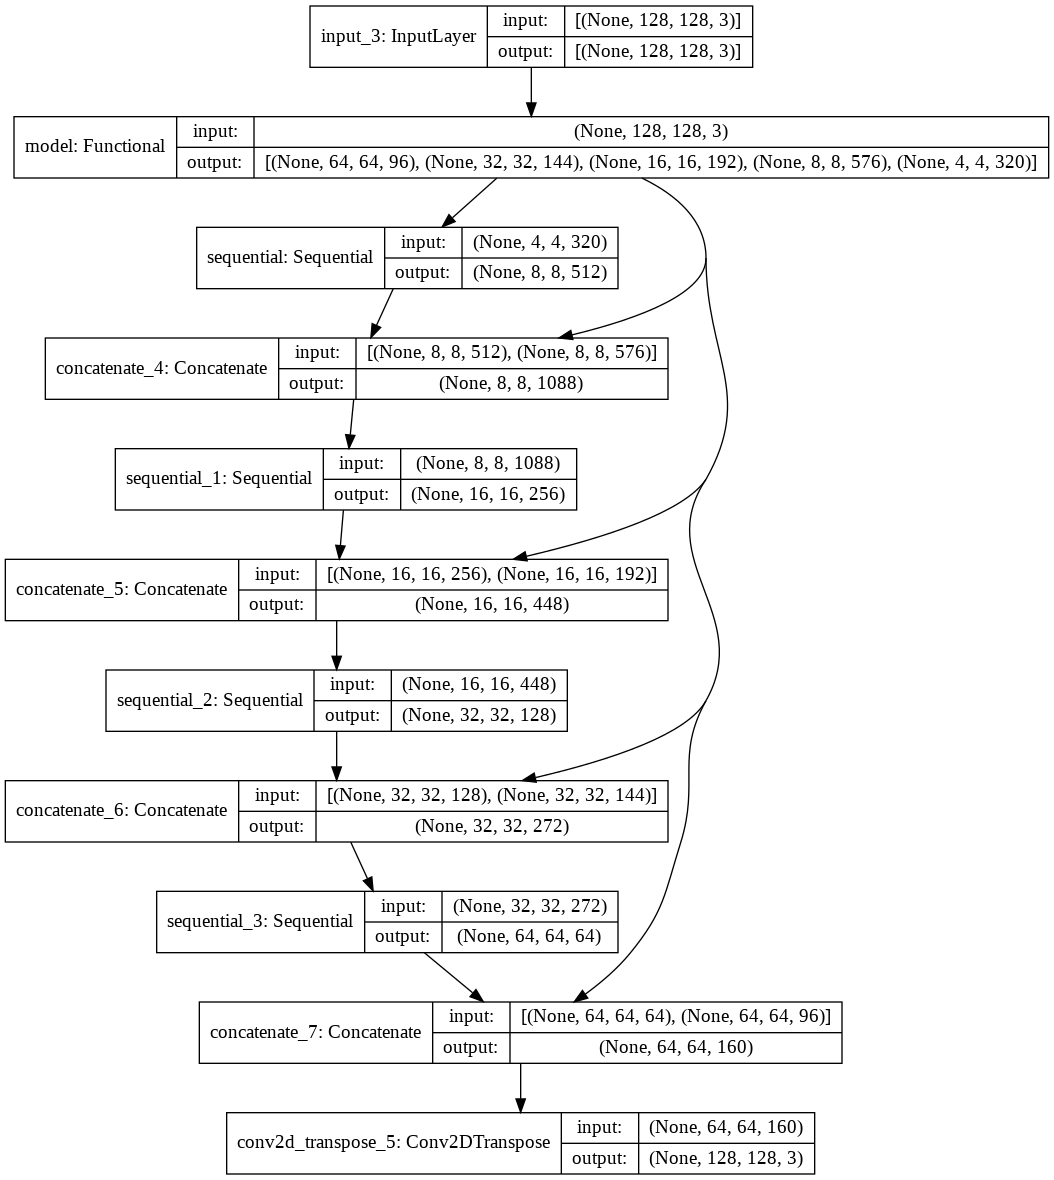

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

CJ: Try out the model to see what it predicts before training, i.e., when the decoder portion of the model is still randomly initialized. You should get crap.

Note that create_mask is just taking the argmax of the 3 channels per pixel, and declaring that to be the predicted label.


In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

CJ: Now look at what gets predicted before you train. It's crap.

In [ ]:
def show_predictions(dataset=test_batches, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

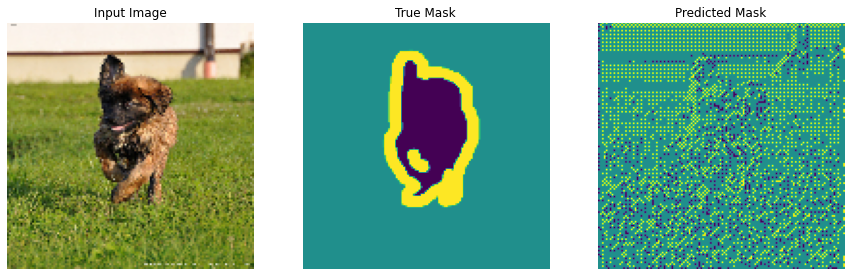

In [ ]:
show_predictions()

The callback defined below is used to observe how the model improves while it is training.

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

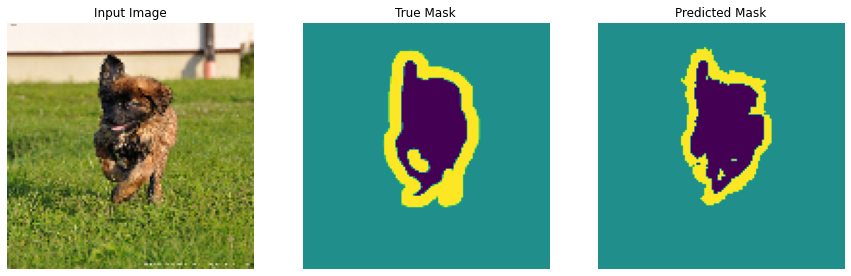


Sample Prediction after epoch 20



In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

CJ: Plot the training and test loss function over 20 epochs (not very many). Both drop a great deal at first. The training loss continues to drop more slowly, but the validation loss is stuck. 

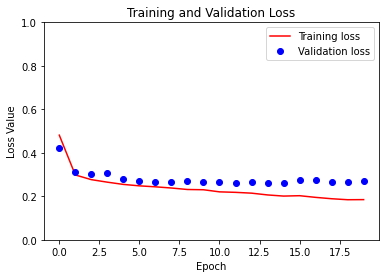

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Make predictions

Now make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

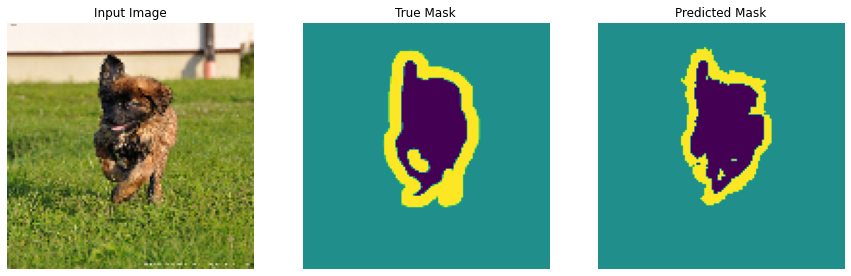

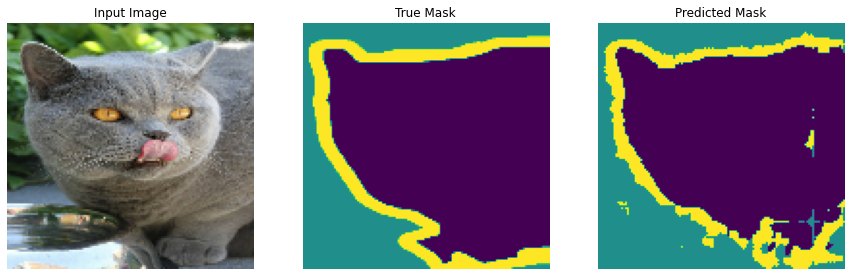

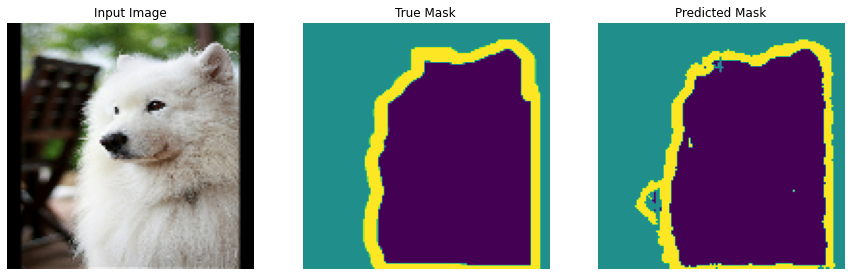

In [ ]:
show_predictions(test_batches, 3)

## Optional: Imbalanced classes and class weights

Semantic segmentation datasets can be highly imbalanced meaning that particular class pixels can be present more inside images than that of other classes. Since segmentation problems can be treated as per-pixel classification problems we can deal with the imbalance problem by weighing the loss function to account for this. It's a simple and elegant way to deal with this problem. See the [imbalanced classes tutorial](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data).

To [avoid ambiguity](https://github.com/keras-team/keras/issues/3653#issuecomment-243939748), `Model.fit` does not support the `class_weight` argument for inputs with 3+ dimensions.

In [ ]:
try:
  model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
  assert False
except Exception as e:
  print(f"{type(e).__name__}: {e}")

ValueError: `class_weight` not supported for 3+ dimensional targets.


So in this case you need to implement the weighting yourself. You'll do this using sample weights: In addition to `(data, label)` pairs, `Model.fit` also accepts `(data, label, sample_weight)` triples.

`Model.fit` propagates the `sample_weight` to the losses and metrics, which also accept a `sample_weight` argument. The sample weight is multiplied by the sample's value before the reduction step. For example:

---
CJ What's going on here? First we need to understand SparseCategoricalCrossentropy. 

Per pixel, cross entropy loss is 

$$
-\sum p_i\text{log}(q_i).
$$

I assume the target (true) value at a pixel is given by p.

So for a 3-channel output, if the one-hot-encoded label is (1,0,0) and the result was (1/2, 1/3, 1/6), then cross entropy loss according to this formula is log(2).

Note that cross entropy is not the same as KL divergence. Cross entropy is the H(P,Q) part of the formula $(P||Q)=H(P,Q) - H(P)$.

---

Now that we understand cross-entropy, I have to wonder what 'label' and 'prediction' mean below. Label can't be one-hot encoded because both terms are 0. So presumably 'label' contains two labels, each is 0, and the predictions are two values per label, with logits instead of values that sum to 1. 

So sample_weights must be a list of weights to apply to the sum of all the terms in the loss. In this case there will be two terms in the loss, one per label. 


That is, I think the total (unweighted) loss in this case is:

$$
-(1\cdot\text{log}(0.5) + 0\cdot\text{log}(0.5) + -(1\cdot\text{log}(0.1) + 0\cdot\text{log}(0.9)). 
$$

But it looks like the function actually returns a vector with a value per label, that you would sum to get the total loss. Let's test that theory. Here's what the function does:


In [ ]:
label = [0,0]
prediction = [[0.5, 0.5], [0.1, 0.9]] 

loss = tf.losses.SparseCategoricalCrossentropy(from_logits=False,
                                               reduction=tf.losses.Reduction.NONE)
loss(label, prediction).numpy()

array([0.6931472, 2.3025851], dtype=float32)

CJ: Here's code that does the same thing I think the loss function does: yes. That log is base 10, not base 2.

In [ ]:
from math import log
def testfunction(vp, vq): 
  value = 0
  for p, q in zip(vp, vq):
    value = value + -p*log(q)
  return value

def onehot_encode_label(label):
  if label==0:
    return [1, 0]
  elif label==1:
    return [0, 1]

result = [testfunction(onehot_encode_label(vp), vq) for (vp, vq) in zip(label, prediction)]
print(result)

[0.6931471805599453, 2.3025850929940455]


CJ: The sample weights are simply multiplying the pixel-wise results of the cross-entropy computation, before the pixel-wise results are summed. So you would define an image of the same size as the label and prediction, consisting of sample weights, and pass that in as sample_weight. The values in sample_weight would depend on your truth mask, and upweight rare classes.

In [ ]:
sample_weight = [1, 10] 

loss = tf.losses.SparseCategoricalCrossentropy(from_logits=False,
                                               reduction=tf.losses.Reduction.NONE)
loss(label, prediction, sample_weight).numpy()

array([ 0.6931472, 23.025852 ], dtype=float32)

So to make sample weights for this tutorial you need a function that takes a `(data, label)` pair and returns a `(data, label, sample_weight)` triple. Where the `sample_weight` is a 1-channel image containing the class weight for each pixel. 

The simplest possible implementation is to use the label as an index into a `class_weight` list.

CJ: reduce_sum does what? Adds the terms.

In [ ]:
tf.reduce_sum(tf.constant([2.0, 2.0, 1.0]))

<tf.Tensor: shape=(), dtype=float32, numpy=5.0>

In [ ]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([2.0, 2.0, 1.0])

  #normalize class weights
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

CJ: The resulting dataset elements contain 3 images each:

In [ ]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

CJ: Now you can train a model on this weighted dataset. The weights (2, 2, 1) apply to in-pet, background, and mixed pixels respectively; we are downweighting any prediction errors incurred in the mixed pixel portion of the image, which makes sense. 

In [ ]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [ ]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch=10)

10/10 [==============================] - 7s 286ms/step - loss: 0.2948 - accuracy: 0.6424


## Next steps
Now that you have an understanding of what image segmentation is and how it works, you can try this tutorial out with different intermediate layer outputs, or even different pretrained model. You may also challenge yourself by trying out the [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge/overview) image masking challenge hosted on Kaggle.

You may also want to see the [Tensorflow Object Detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/README.md) for another model you can retrain on your own data. Pretrained models are available on [TensorFlow Hub](https://www.tensorflow.org/hub/tutorials/tf2_object_detection#optional)